In [499]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run prior.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [500]:
from copy import deepcopy

In [501]:
def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg is None or coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [502]:
def run_experiment_multi(configs=None, task_type='classification', config_filter=None,
                         init_prior_scale=0.1, coreset_sizes=[50,100,200], 
                         print_progress=False, ret_std=True, show_vanilla=True):
    """Run complete VCL experiment"""
    if configs is None:
        configs = get_all_configs(task_type, config_filter,
                                  init_prior_scale, coreset_sizes)
    # Initialize models
    models = {c.name: VCLNN(c).to(DEVICE) for c in configs}
    if show_vanilla:
        vanillaNN = VanillaNN(ExperimentConfig()).to(DEVICE) 
        models[VANILLA_MODEL] = vanillaNN

    results = {}
    results_std = {}
    for model_name, model in models.items():
        res, res_std = run_experiment_for(model, print_progress=print_progress)
        results[model_name] = res
        results_std[model_name] = res_std
    return results if not ret_std else (results, results_std)

In [416]:
exp_config = ExperimentConfig(task_type='classification', prior_type='exponential')
exp_res, exp_res_std = run_experiment_multi(configs=[exp_config])

p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E_abs tensor(0.0637)
p_mu tensor(0.)
p_sigma tensor(0.1000)
E

KeyboardInterrupt: 

# Results

In [503]:
torch.manual_seed(7)
np.random.seed(7)
configs = get_all_configs('classification')
cla_all_results, cla_all_std = run_experiment_multi(configs=configs, task_type='classification')

In [505]:
cla_all_results

{'GaussianVCL (Random, 200)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.88107812, 0.        , 0.        , 0.        ],
        [0.99956597, 0.89813282, 0.90516625, 0.        , 0.        ],
        [0.99956597, 0.93192969, 0.92872284, 0.98765706, 0.        ],
        [0.99956597, 0.89816797, 0.95105278, 0.99267578, 0.89789809]]),
 'ExpVCL (Kcenter, 50)': array([[0.99913194, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.90799218, 0.        , 0.        , 0.        ],
        [0.99956597, 0.92558203, 0.88233612, 0.        , 0.        ],
        [1.        , 0.92157032, 0.88636147, 0.96845804, 0.        ],
        [0.99956597, 0.92890625, 0.90333222, 0.98503947, 0.85800474]]),
 'GaussianVCL (Random, 100)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.96229687, 0.        , 0.        , 0.        ],
        [0.99956597, 0.96130859, 0.96063977, 0.        , 0.        ],
    

In [506]:
mean_aggr_results(cla_all_results, aggr='all')

{'GaussianVCL (Random, 200)': 0.9436543184436029,
 'ExpVCL (Kcenter, 50)': 0.9292017532305585,
 'GaussianVCL (Random, 100)': 0.9685218647536304,
 'ExpVCL (Kcenter, 200)': 0.9303269983414146,
 'ExpVCL (Random, 50)': 0.9453674508631229,
 'GaussianVCL (Kcenter, 50)': 0.897016469736894,
 'ExpVCL (Random, 200)': 0.9623816622793674,
 'ExpVCL (Kcenter, 100)': 0.8909048901498318,
 'GaussianVCL (Random, 50)': 0.9192194078365962,
 'ExpVCL (None)': 0.9739410733679931,
 'GaussianVCL (Kcenter, 200)': 0.9032910292264488,
 'ExpVCL (Random, 100)': 0.9640835096687079,
 'GaussianVCL (Kcenter, 100)': 0.8965451323572132,
 'GaussianVCL (None)': 0.9847571187631952,
 'Vanilla': 0.9709746509542068}

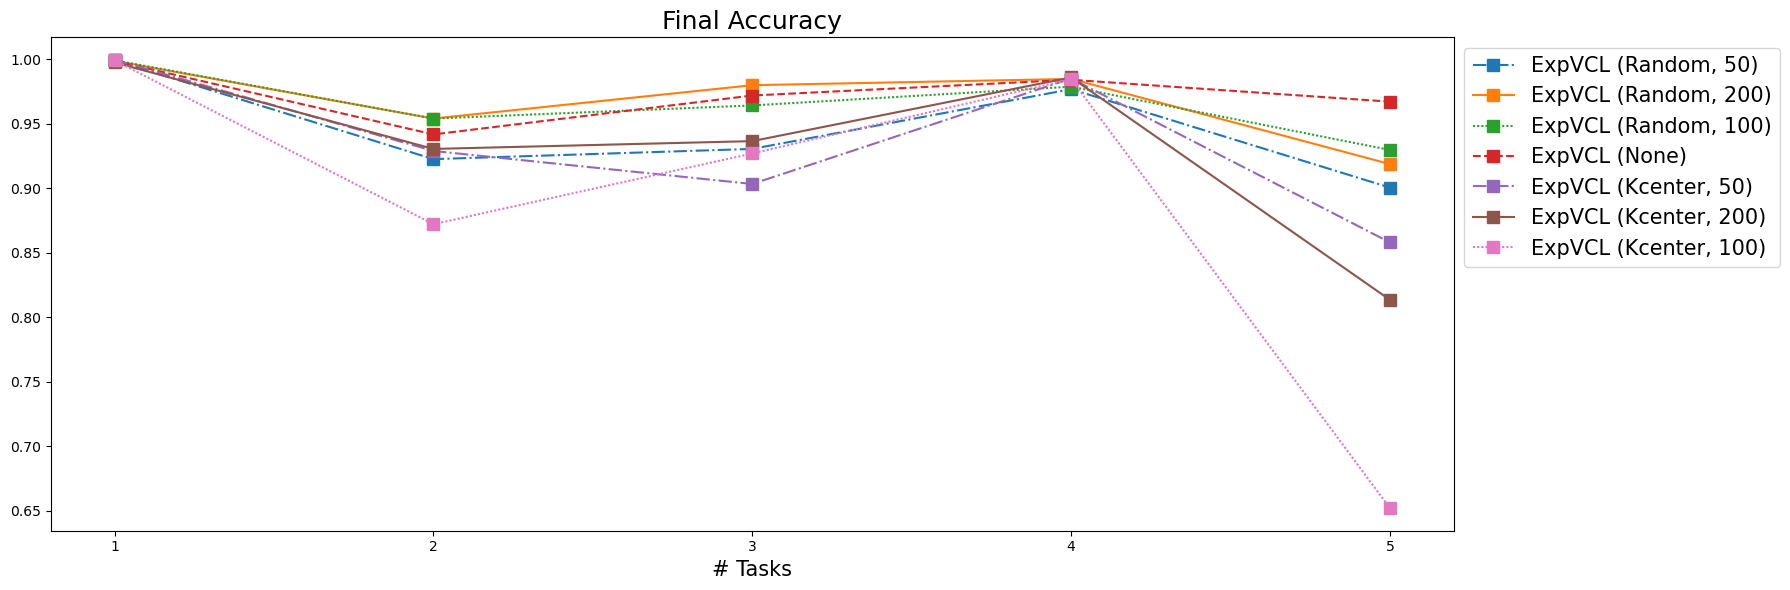

In [507]:
%run utils.ipynb
# Compare within each type of models
plot_final_results(ExperimentConfig(task_type='classification'), 
                   cla_all_results, 
                   mname_filter=(lambda m : 'Exp' in m))

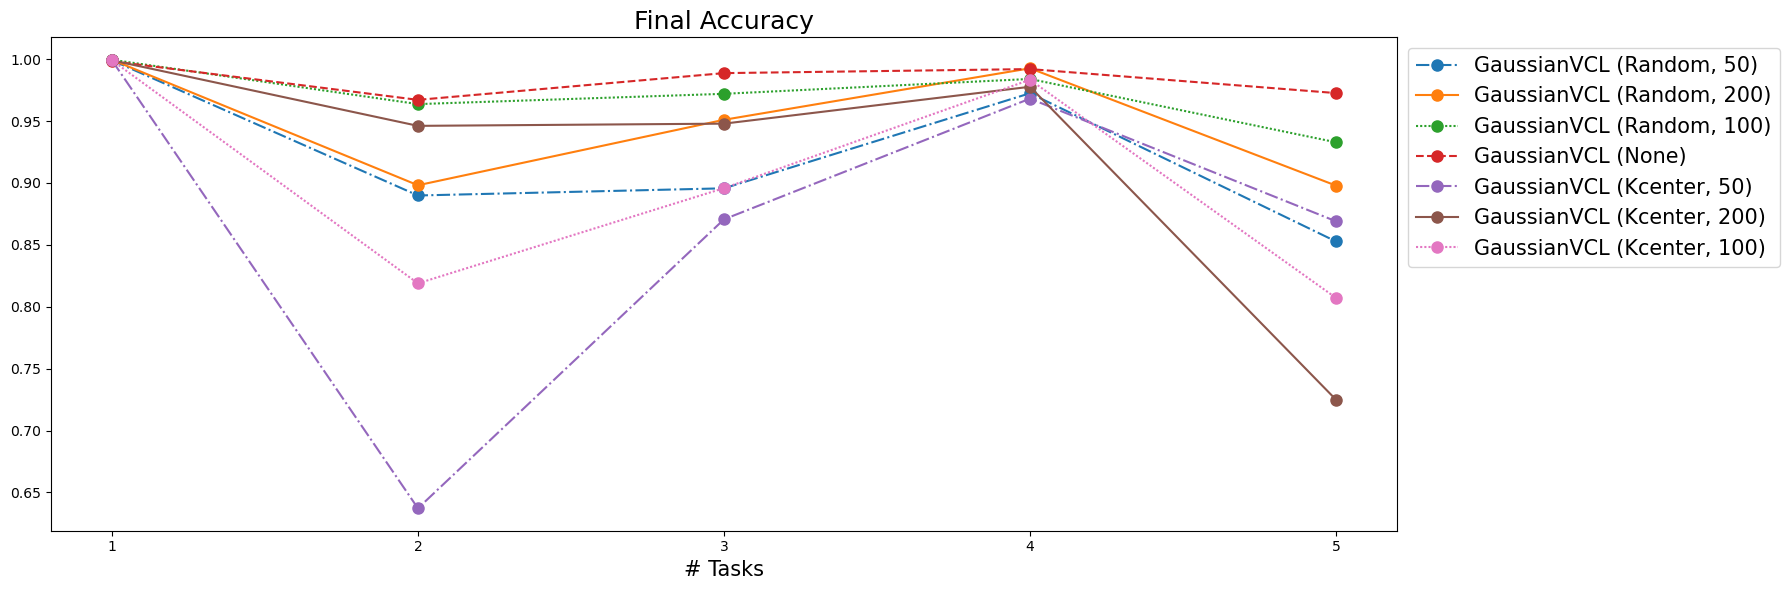

In [508]:
# Exp VCL only
plot_final_results(ExperimentConfig(task_type='classification'), 
                   cla_all_results, 
                   mname_filter=(lambda m : 'Gaussian' in m))

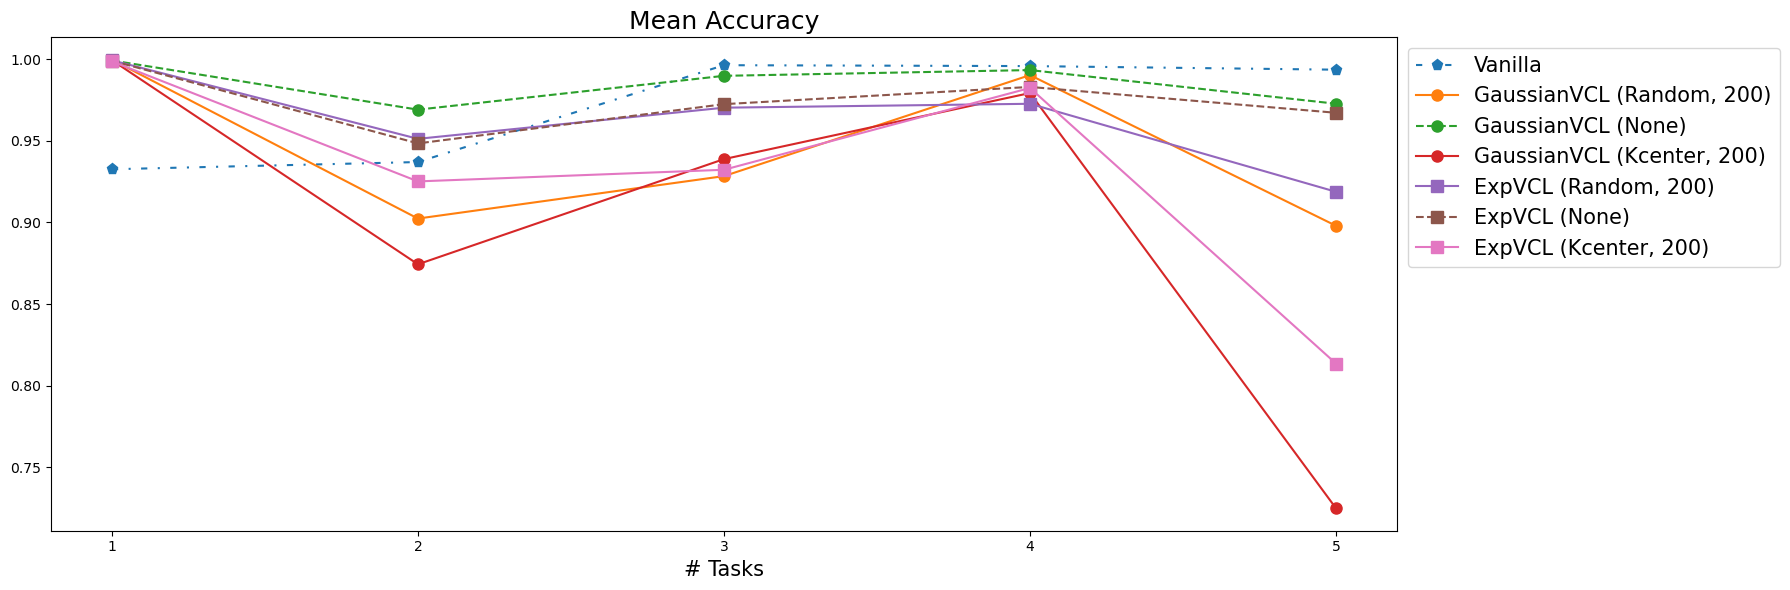

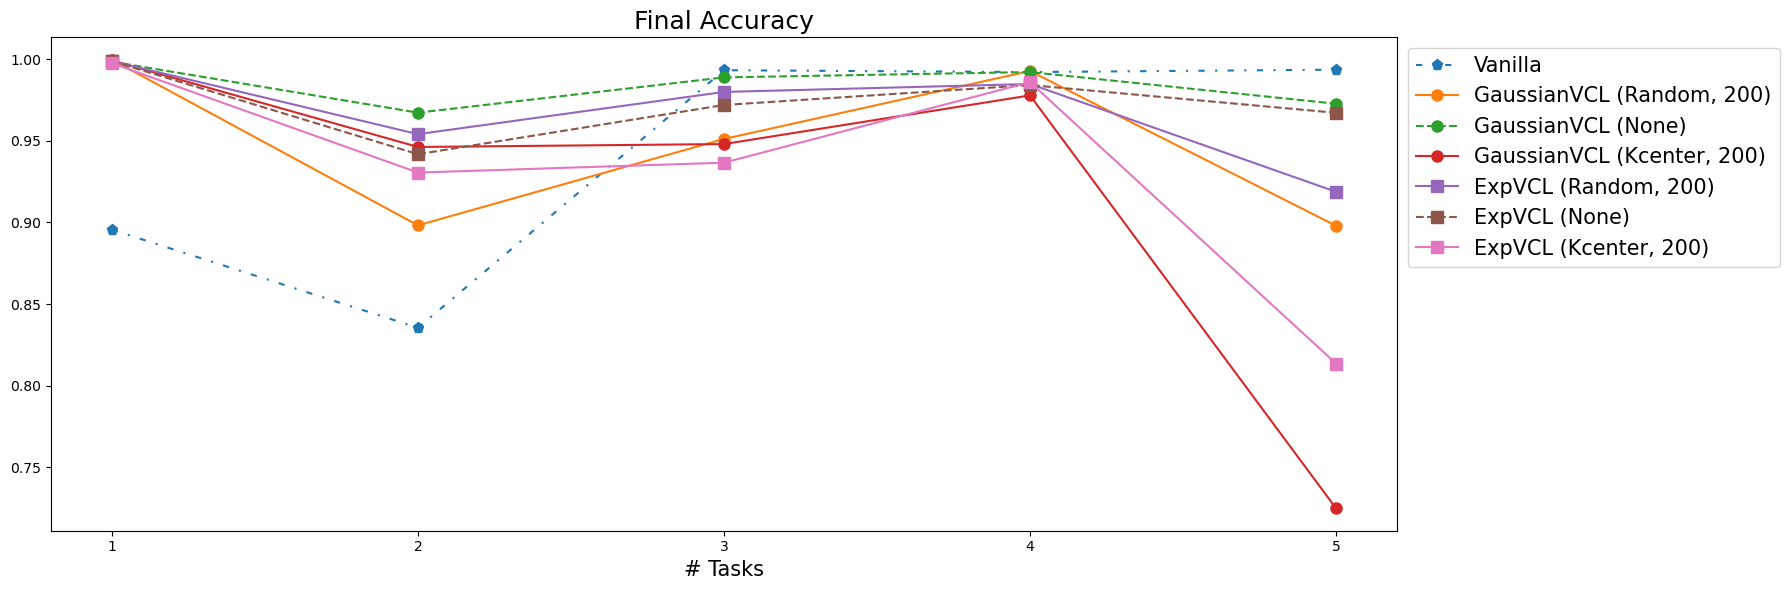

In [509]:
plot_mean_results(ExperimentConfig(task_type='classification'), 
                  cla_all_results, 
                  mname_filter=(lambda m : 'None' in m or '200' in m or m == VANILLA_MODEL))
plot_final_results(ExperimentConfig(task_type='classification'), 
                   cla_all_results, 
                   mname_filter=(lambda m : 'None' in m or '200' in m  or m == VANILLA_MODEL))

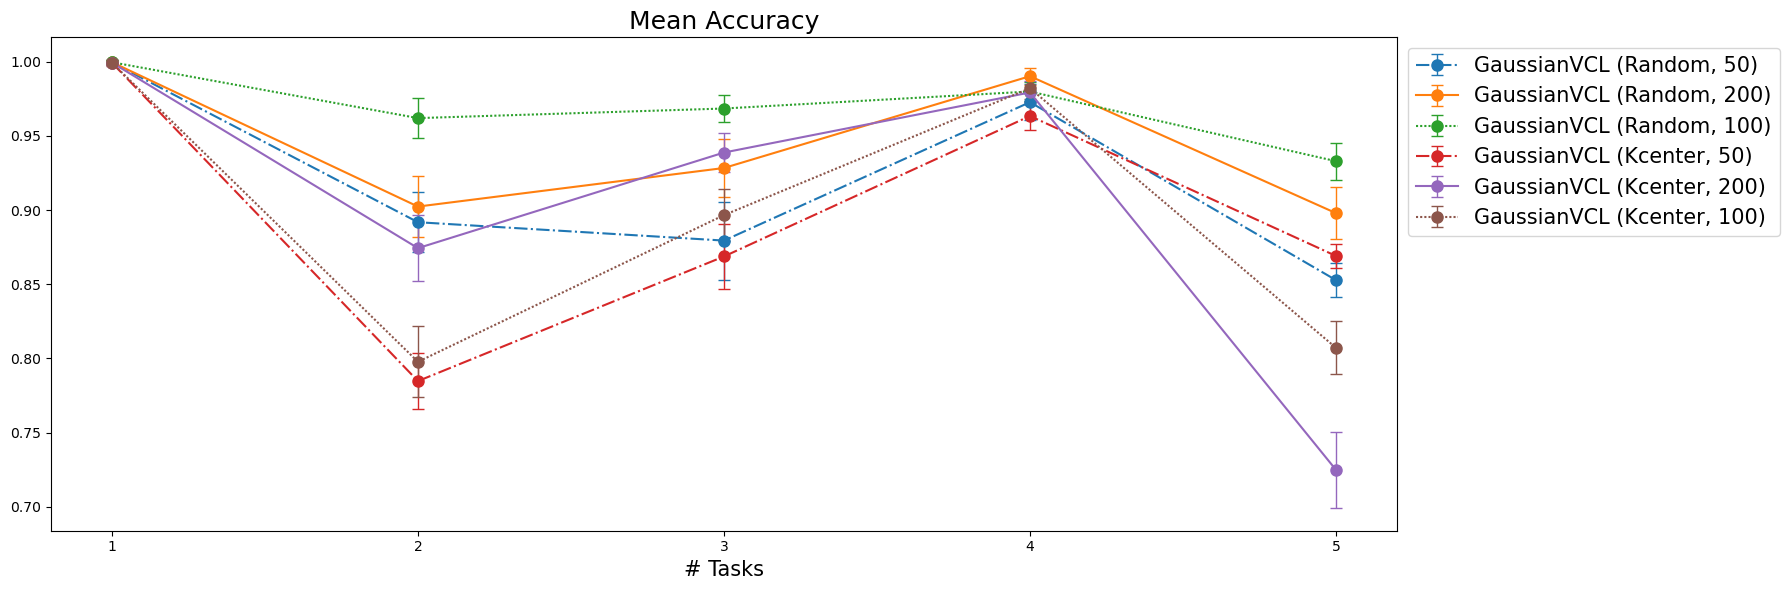

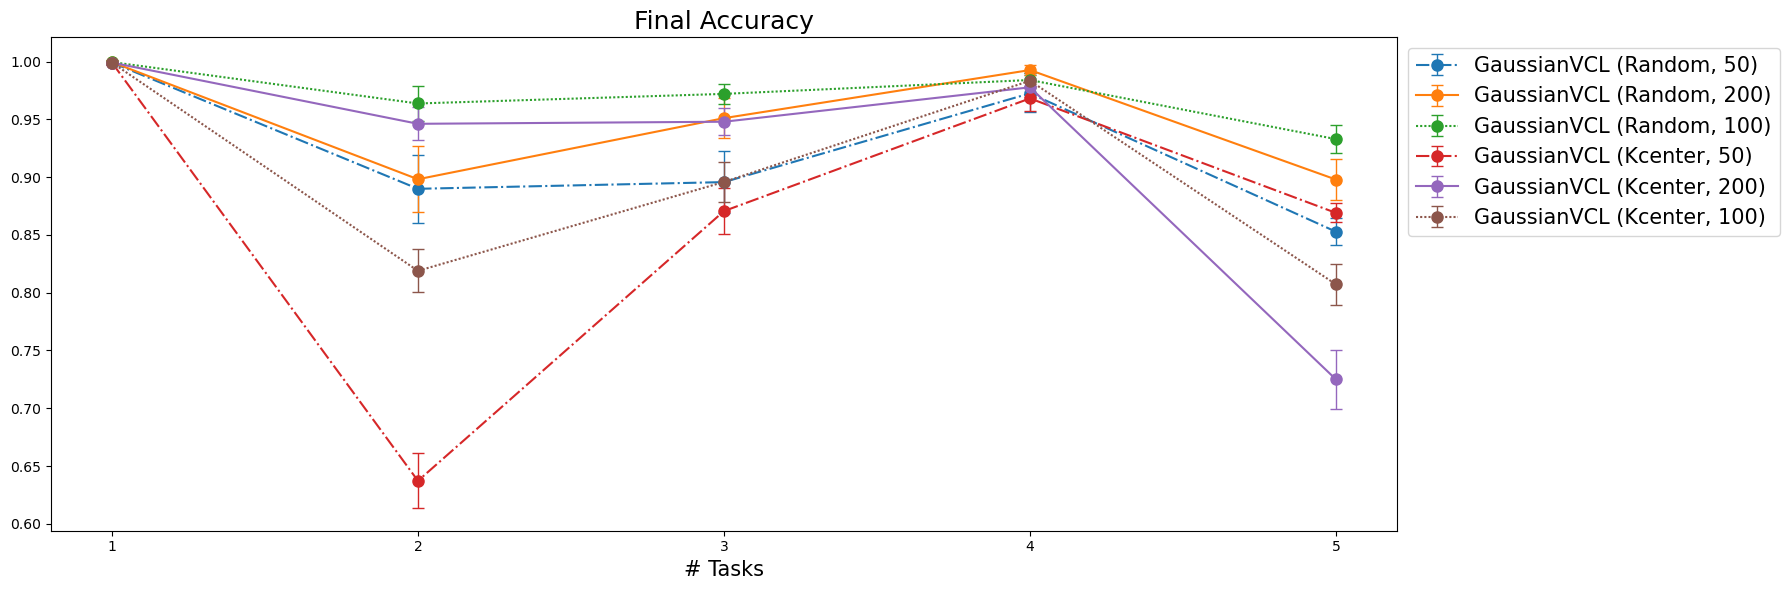

In [510]:
plot_mean_results(ExperimentConfig(task_type='classification'), 
                  cla_all_results, results_std=cla_all_std,
                  mname_filter=(lambda m : 'None' not in m and 'Gaussian' in m)) 
plot_final_results(ExperimentConfig(task_type='classification'), 
                   cla_all_results, results_std=cla_all_std,
                   mname_filter=(lambda m : 'None' not in m and 'Gaussian' in m))

In [504]:
torch.manual_seed(7)
np.random.seed(7)
configs = get_all_configs('regression')
reg_all_results, reg_all_std = run_experiment_multi(configs=configs, task_type='regression')

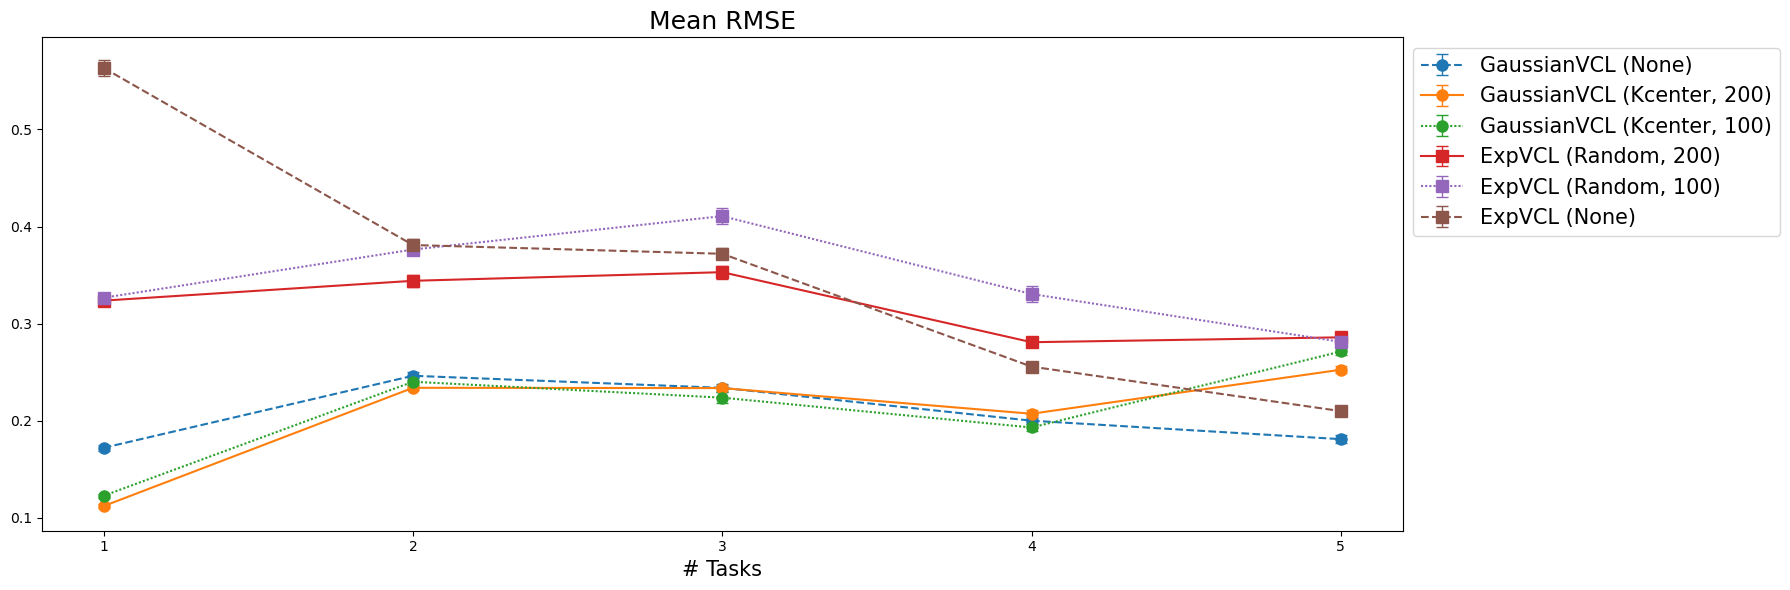

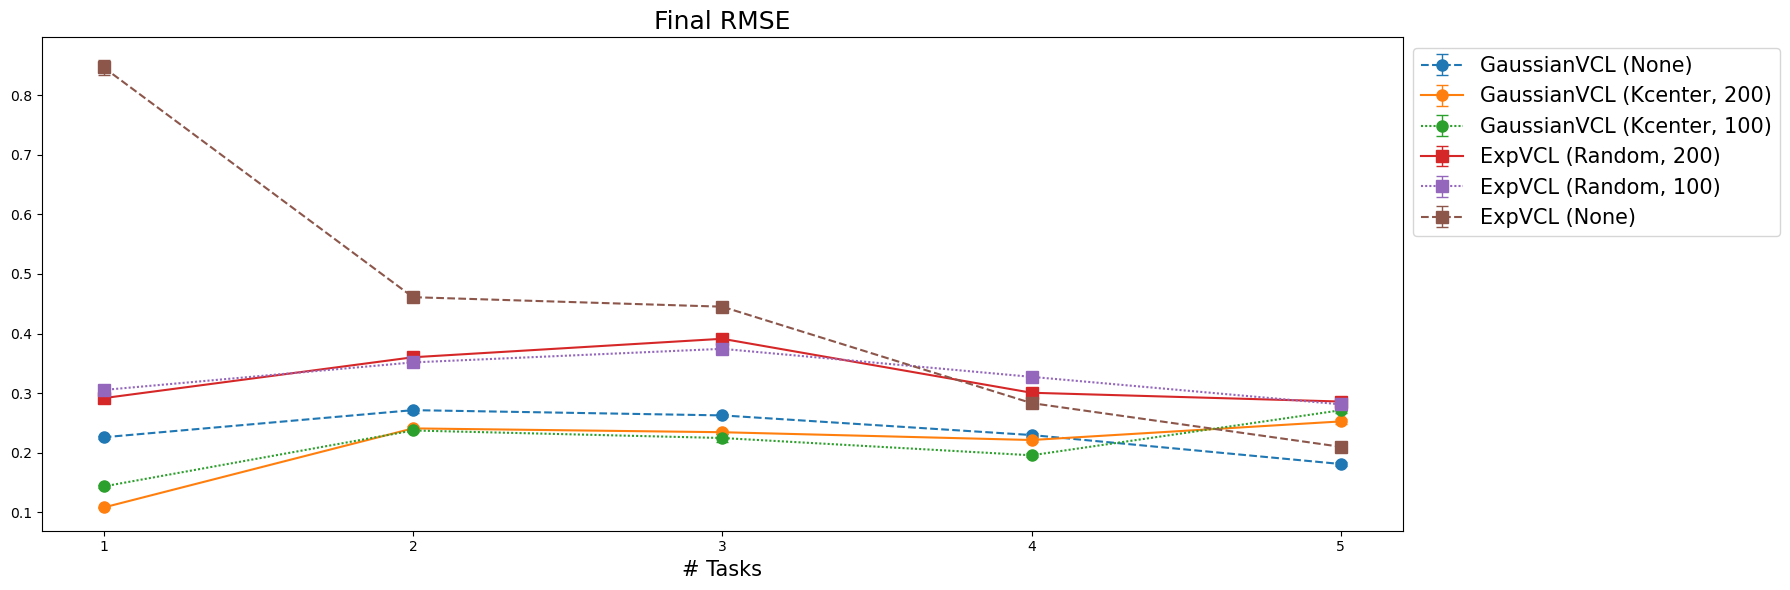

In [511]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'None' in m or (('ExpVCL (Random' in m or 'GaussianVCL (Kcenter' in m) and '00' in m)))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'None' in m or (('ExpVCL (Random' in m or 'GaussianVCL (Kcenter' in m) and '00' in m)))

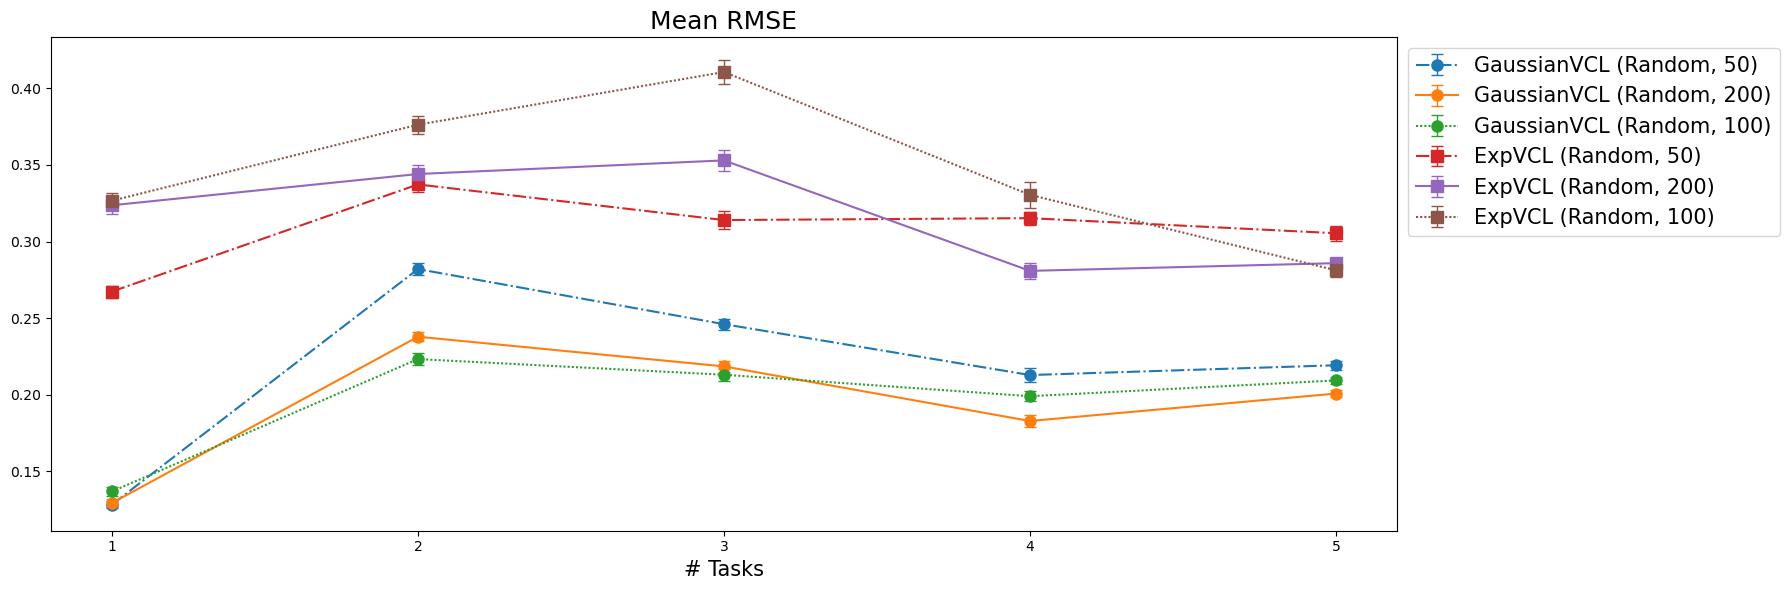

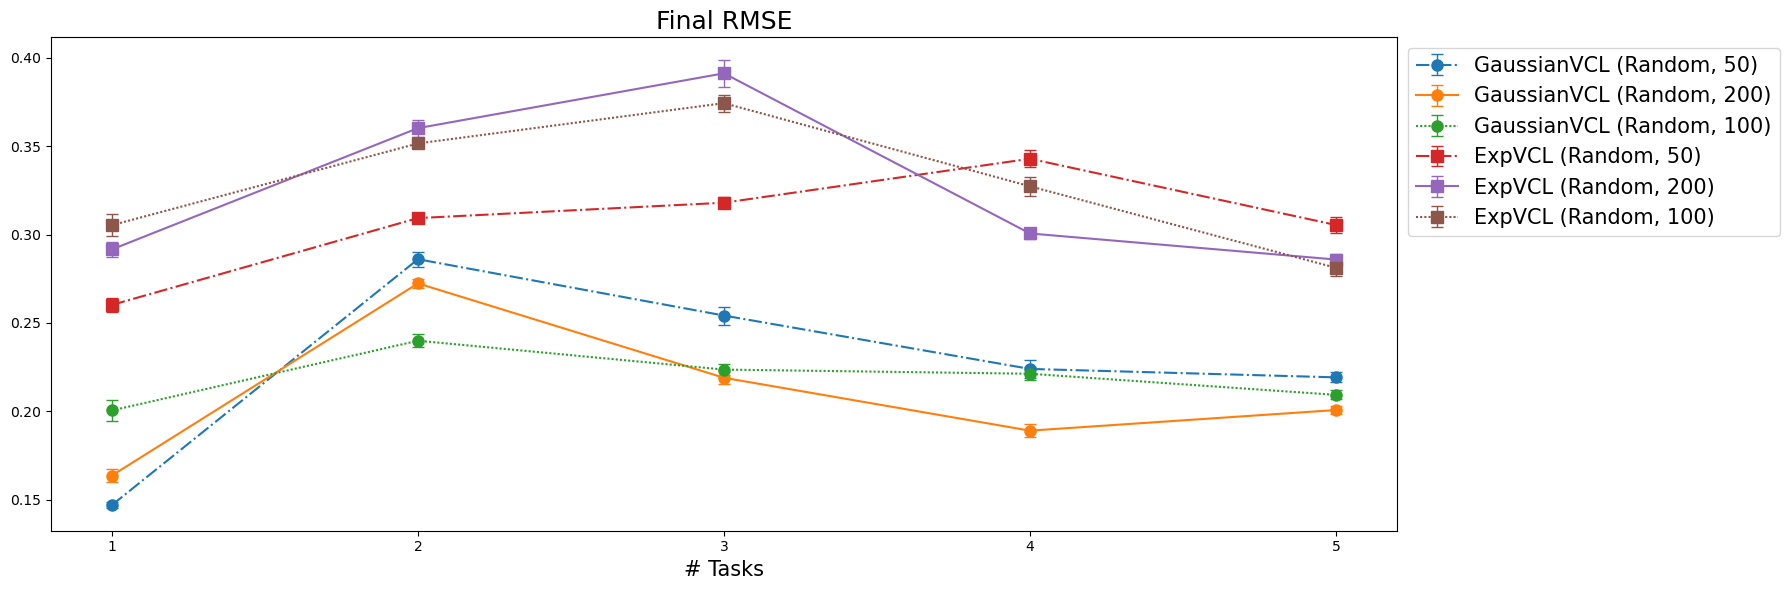

In [512]:
# Compare different coreset sizes for Random coreset
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'Random' in m))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'Random' in m))

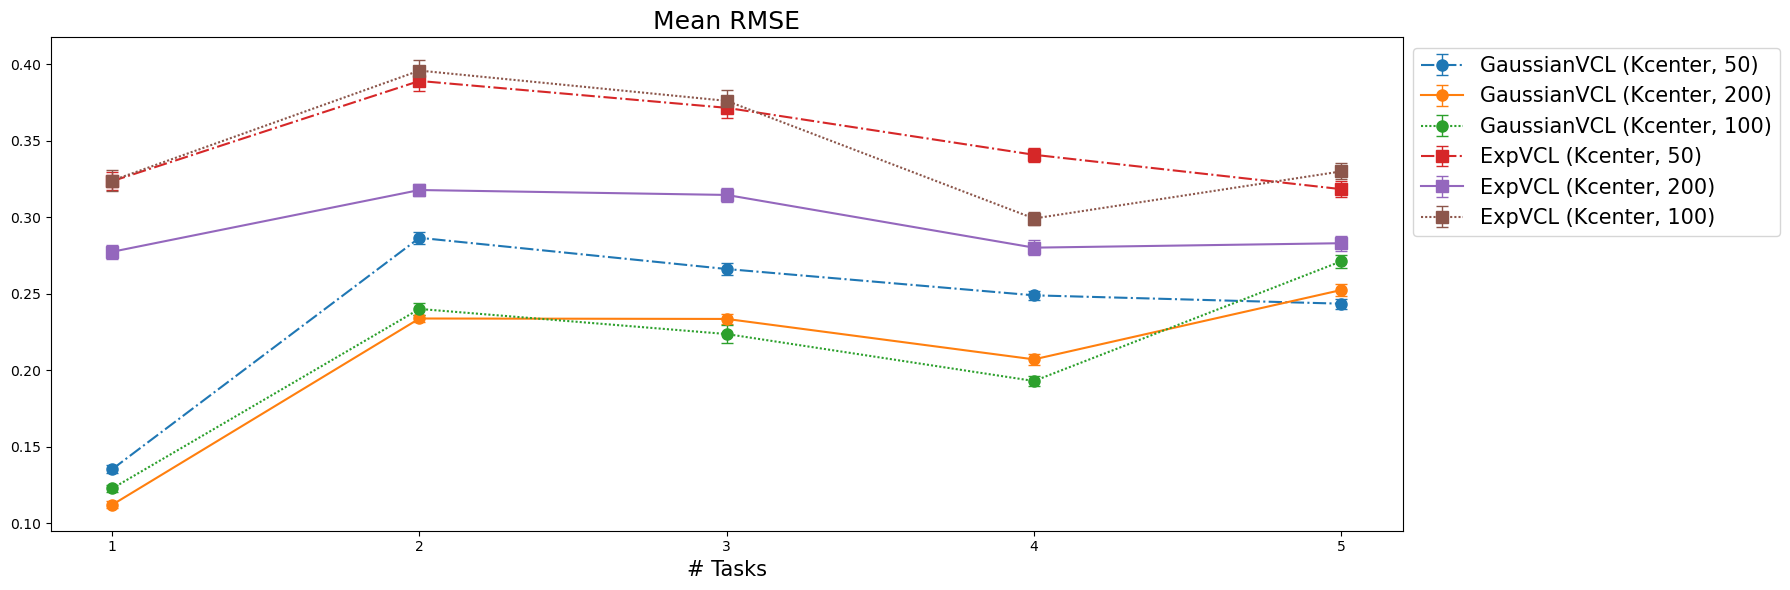

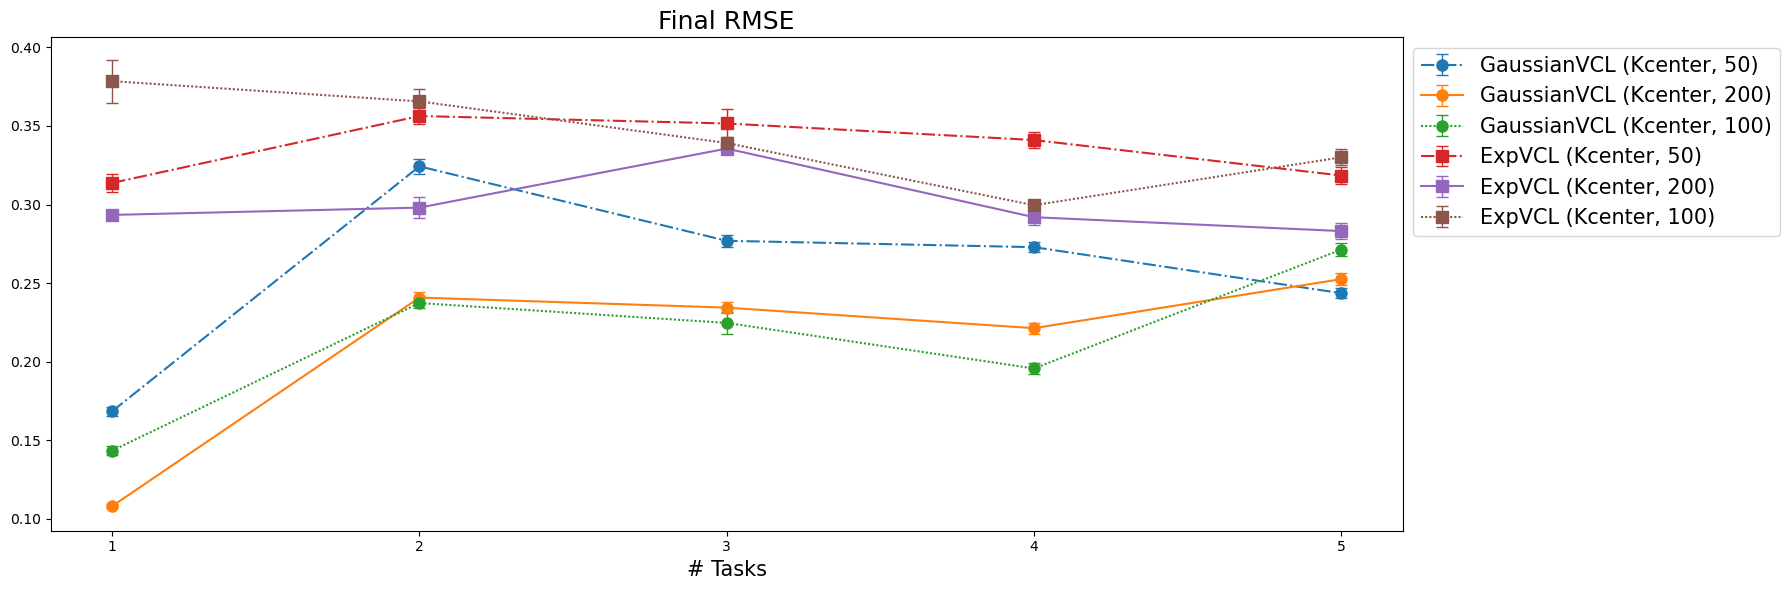

In [513]:
# Compare different coreset sizes for KCenter coreset
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'K' in m))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'None' not in m and m != VANILLA_MODEL and 'K' in m))

In [498]:
export_results(cla_all_results, 'classification', datatype='mean')
export_results(cla_all_std, 'classification', datatype='std')
export_results(reg_all_results, 'regression', datatype='mean')
export_results(reg_all_std, 'regression', datatype='std')